In [461]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from transformers import BertTokenizer, BertModel
from bertopic import BERTopic
from transformers import pipeline
import torch
import torch.nn as nn
import torch.optim as optim
import torchviz
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from wordcloud import WordCloud
import spacy
import folium
from geopy.geocoders import Nominatim
from IPython.display import IFrame
from collections import Counter


In [433]:
df_one = pd.read_csv('tweets1.csv')
df_two = pd.read_csv('tweets2.csv')
merged_df = pd.concat([df_one, df_two])
duplicates = merged_df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

0

In [434]:
merged_df.count()

id          18983
keyword     18922
location    13032
text        18983
target      18983
dtype: int64

In [436]:
df_train, df_test = train_test_split(merged_df, test_size=0.2, random_state=42)
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)


In [437]:
df_train.head(10)

,id,keyword,location,text,target
3181,3181,deaths,Hong Kong,"CCP is mimicking Nazi's evil acts, but still t...",0
6638,6638,hostages,NaN,"Amanpour's guest is , the same woman that clim...",0
2484,2484,collided,Wakanda,"Recently, I have seen a lot of people putting ...",0
1801,1801,buildings%20on%20fire,NaN,"Hoo, some less-terribly-priced Lego Fire Briga...",0
5903,8431,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1
8323,8323,quarantined,Singapore,A Chinese woman has been quarantined in Thaila...,1
3601,5141,fatal,"Jaipur, Rajasthan, India",Success is not permanent &amp; failure is not ...,0
10240,10240,thunderstorm,"Sioux Falls, SD",NWSSevereTstorm Severe Thunderstorm Warning in...,1
1962,1962,bush%20fires,Carshalton,"Yesterday, I said kangaroos were digging holes...",1
10065,10065,terrorist,"Florida, USA",General Salami was one of the worst terrorists...,0


In [439]:
print('Train INFO')
print(df_train.info)
print('--------------'*10)
print('Test INFO')
print(df_test.info)

Train INFO
<bound method DataFrame.info of         id                keyword        location  \
3181  3181                 deaths       Hong Kong   
6638  6638               hostages             NaN   
2484  2484               collided         Wakanda   
1801  1801  buildings%20on%20fire             NaN   
5903  8431              sandstorm             USA   
...    ...                    ...             ...   
3671  3671               derailed  Southern Reach   
4351  4351                  drown        Near you   
5390  7691                  panic             NaN   
860   1242                  blood             NaN   
8182  8182                 police             NaN   

                                                   text  target  
3181  CCP is mimicking Nazi's evil acts, but still t...       0  
6638  Amanpour's guest is , the same woman that clim...       0  
2484  Recently, I have seen a lot of people putting ...       0  
1801  Hoo, some less-terribly-priced Lego Fire Briga... 

In [440]:
print('NaN in Train Data')
print(df_train.isna().sum())
print('------'*10)
print('The Counts of Normal(0) and Disaster(1)')
print(df_train.target.value_counts())

NaN in Train Data
id             0
keyword       52
location    4730
text           0
target         0
dtype: int64
------------------------------------------------------------
The Counts of Normal(0) and Disaster(1)
0    10869
1     4317
Name: target, dtype: int64


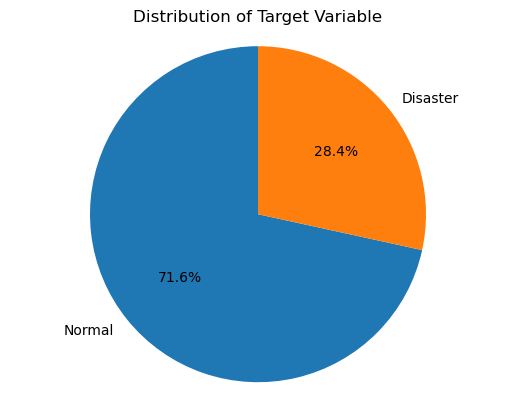

In [441]:
plt.pie(df_train.target.value_counts(), labels=['Normal', 'Disaster'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.axis('equal')
plt.show()

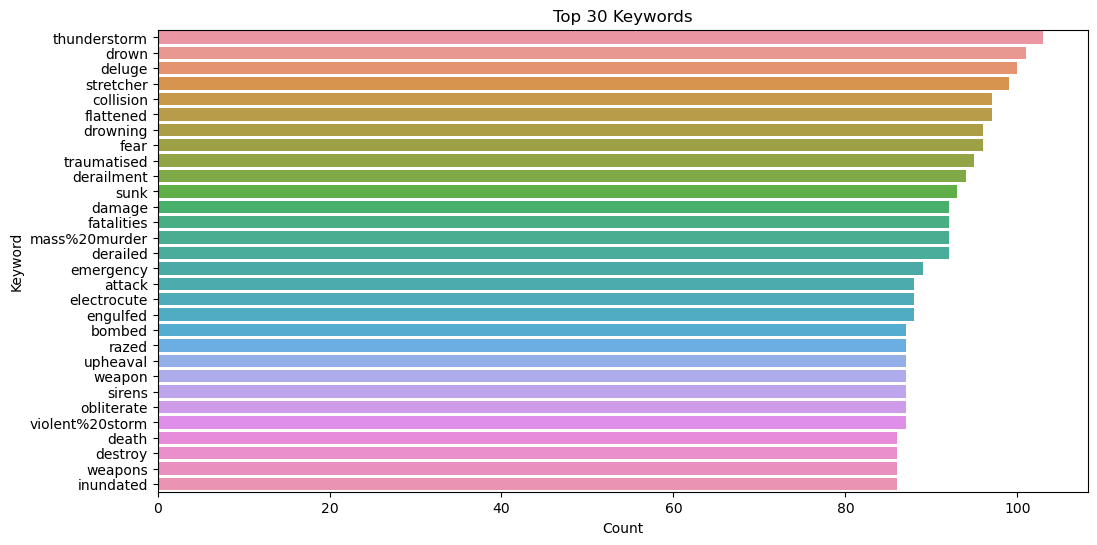

In [442]:
keyword_counts = df_train.keyword.value_counts().head(30)
plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_counts.values, y=keyword_counts.index)
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Top 30 Keywords')
plt.show()


In [443]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A11M1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [444]:
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_train['cleaned_text'] = df_train.text.apply(preprocess_text)
df_test['cleaned_text'] = df_test.text.apply(preprocess_text)


In [445]:
df_train.head(10)

,id,keyword,location,text,target,cleaned_text
3181,3181,deaths,Hong Kong,"CCP is mimicking Nazi's evil acts, but still t...",0,ccp mimicking nazis evil acts still people arg...
6638,6638,hostages,NaN,"Amanpour's guest is , the same woman that clim...",0,amanpours guest woman climbed american embassy...
2484,2484,collided,Wakanda,"Recently, I have seen a lot of people putting ...",0,recently seen lot people putting legs dashboar...
1801,1801,buildings%20on%20fire,NaN,"Hoo, some less-terribly-priced Lego Fire Briga...",0,hoo lessterriblypriced lego fire brigades town...
5903,8431,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,watch airport get swallowed sandstorm minute
8323,8323,quarantined,Singapore,A Chinese woman has been quarantined in Thaila...,1,chinese woman quarantined thailand mystery str...
3601,5141,fatal,"Jaipur, Rajasthan, India",Success is not permanent &amp; failure is not ...,0,success permanent amp failure fatal
10240,10240,thunderstorm,"Sioux Falls, SD",NWSSevereTstorm Severe Thunderstorm Warning in...,1,nwsseveretstorm severe thunderstorm warning in...
1962,1962,bush%20fires,Carshalton,"Yesterday, I said kangaroos were digging holes...",1,yesterday said kangaroos digging holes save jo...
10065,10065,terrorist,"Florida, USA",General Salami was one of the worst terrorists...,0,general salami one worst terrorists democrats ...


In [450]:
df_train.loc[df_train['id'] == 8323].values

array([[8323, 'quarantined', 'Singapore',
        'A Chinese woman has been quarantined in Thailand with a mystery strain of coronavirus just days ahead of the Lunar… https://t.co/SmJO59Fs4K',
        1,
        'chinese woman quarantined thailand mystery strain coronavirus days ahead lunar']],
      dtype=object)

,id,keyword,location,text,target,cleaned_text,extracted_locations
8165,8165,police,"Minhyukville, Chan Land",onion on the phone w police like https://t.co/...,0,onion phone w police like,[]
3275,4700,epicentre,"Charlotte, NC",Tomorrow kick off your weekend with drinks &am...,0,tomorrow kick weekend drinks amp entertainment...,[]
5865,8378,ruin,Boston,Lol The real issue is the the way the NFL is t...,0,lol real issue way nfl trying ruin guys legacy,[]
7639,7639,nuclear%20disaster,"Heart of Texas, United States",They don't want America to know what an unmiti...,0,dont want america know unmitigating disaster i...,[america]
6176,6176,harm,♡X1♡,cj has been saying “compensation for victims” ...,0,cj saying compensation victims theres compensa...,[]
6727,9640,thunderstorm,NaN,Falling asleep to the sounds to thousands of R...,0,falling asleep sounds thousands river plate fa...,[]
5950,5950,floods,"Belper, England",We have no idea how many more rounds there are...,0,idea many rounds weve already shown league amp...,[]
8100,8100,panic,N17,This is cool! Clearly a player we’ve monitored...,0,cool clearly player weve monitored interested ...,[]
9403,9403,snowstorm,"Olympia, Washington State",The great snowstorm of 2020 didn’t materialize...,0,great snowstorm didnt materialize overnight ol...,[]
6547,6547,hijacking,he / him,I believe they're saying the LGBT community sh...,0,believe theyre saying lgbt community lgb commu...,[lgbt]


In [409]:
print('NaN in Train Data')
print(df_train.isna().sum())

NaN in Train Data
id                        0
keyword                  25
location               2854
text                      0
target                    0
cleaned_text              0
extracted_locations       0
dtype: int64


In [367]:
df_train.dropna(subset=['target'], inplace=True)

In [368]:
print('NaN in Train Data')
print(df_train.isna().sum())

NaN in Train Data
id                 0
keyword           44
location        4532
text               0
target             0
cleaned_text       0
dtype: int64


In [389]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_texts = df_train.cleaned_text.tolist()
train_labels = df_train.target.tolist()
val_texts = df_val.cleaned_text.tolist()
val_labels = df_val.target.tolist()
test_texts = df_test.cleaned_text.tolist()

train_labels = torch.tensor(train_labels).float()  # Convert train_labels to tensor and float
val_labels = torch.tensor(val_labels).float()  # Convert val_labels to tensor and float


In [390]:
# Tokenize and encode the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert the encoded inputs and labels into PyTorch tensors
train_input_ids = torch.tensor(train_encodings['input_ids'])
train_attention_mask = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])
val_labels = torch.tensor(val_labels)

test_input_ids = torch.tensor(test_encodings['input_ids'])
test_attention_mask = torch.tensor(test_encodings['attention_mask'])

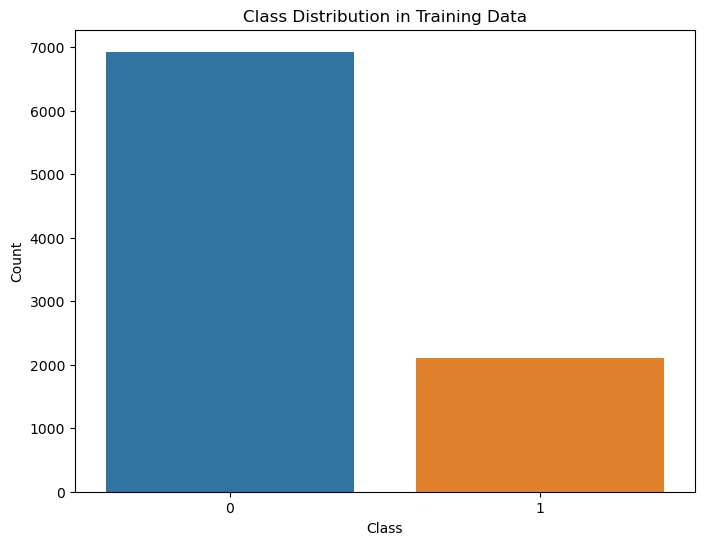

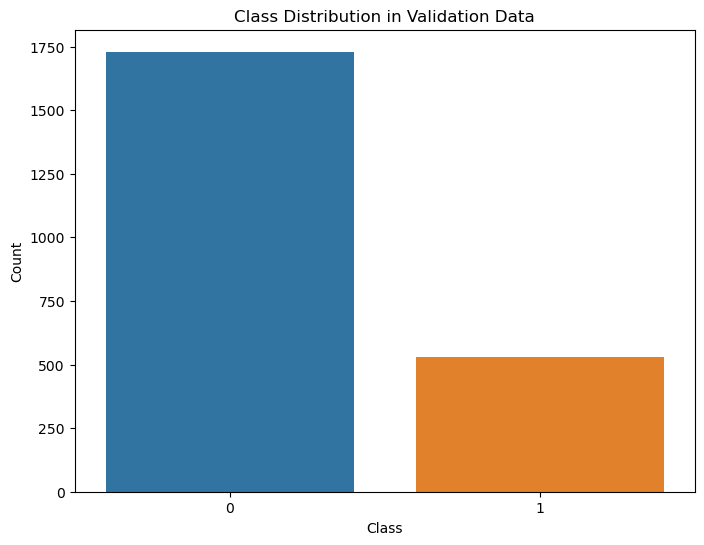

In [391]:
# Class Distribution Plot
train_class_counts = df_train.target.value_counts()
val_class_counts = df_val.target.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=train_class_counts.index, y=train_class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x=val_class_counts.index, y=val_class_counts.values)
plt.title('Class Distribution in Validation Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


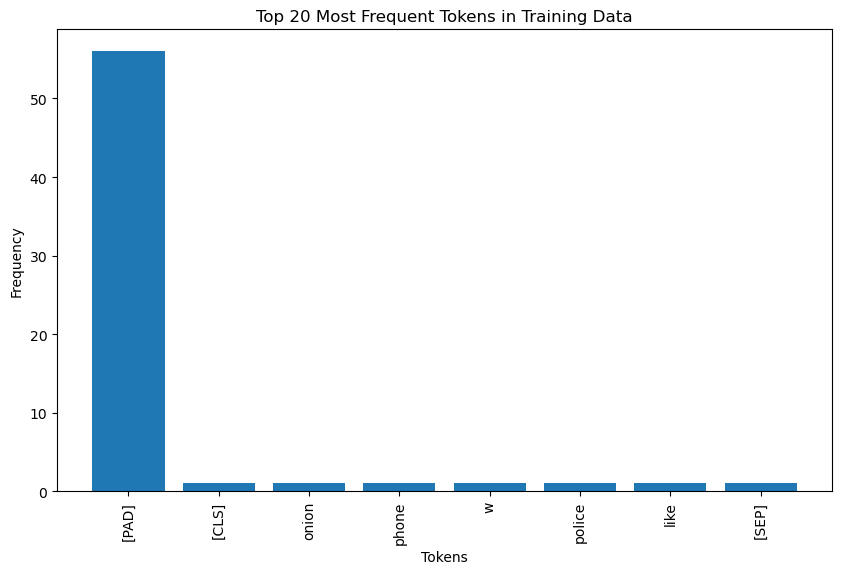

In [457]:
train_tokenized_words = tokenizer.convert_ids_to_tokens(train_input_ids[0])
token_frequency = Counter(train_tokenized_words)
top_20_tokens = token_frequency.most_common(50)

tokens, frequencies = zip(*top_20_tokens)

plt.figure(figsize=(10, 6))
plt.bar(tokens, frequencies)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Tokens in Training Data')
plt.xticks(rotation=90)
plt.show()


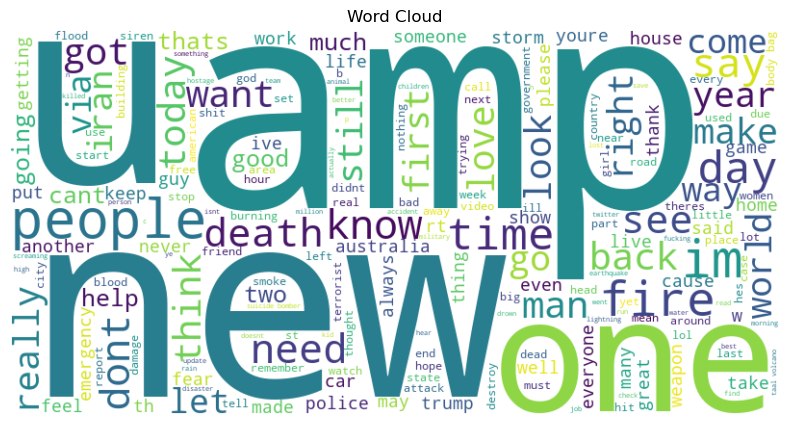

In [372]:
# Word Cloud
all_texts = train_texts + val_texts + test_texts
all_texts_combined = ' '.join(all_texts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

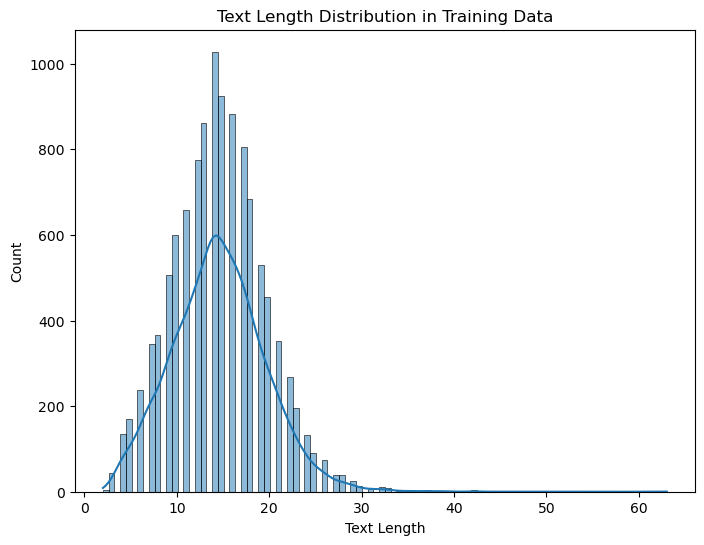

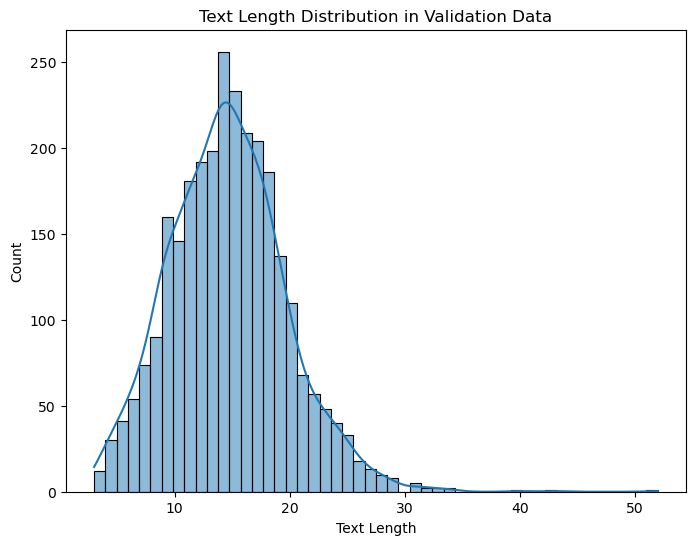

In [373]:
# Text Length Distribution Plot
train_text_lengths = [len(tokenizer.encode(text)) for text in train_texts]
val_text_lengths = [len(tokenizer.encode(text)) for text in val_texts]

plt.figure(figsize=(8, 6))
sns.histplot(train_text_lengths, kde=True)
plt.title('Text Length Distribution in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(val_text_lengths, kde=True)
plt.title('Text Length Distribution in Validation Data')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

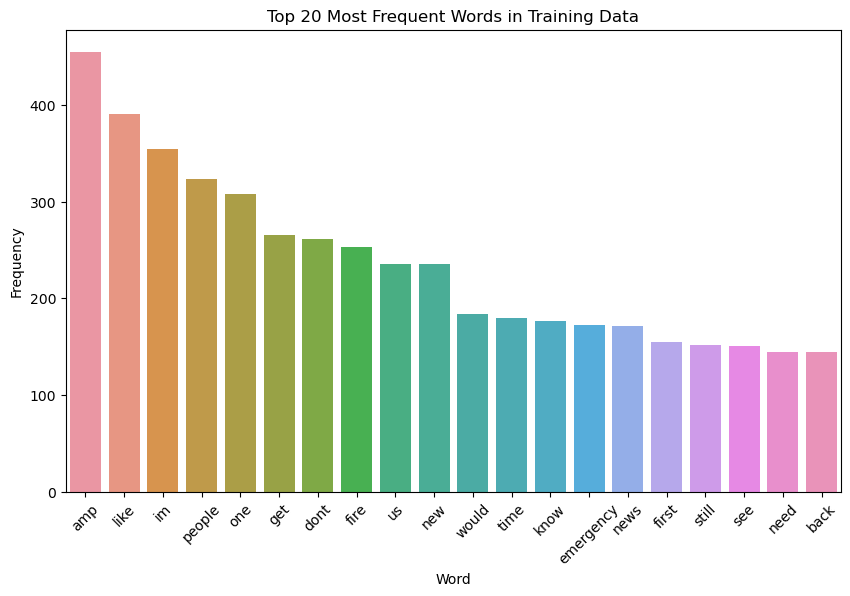

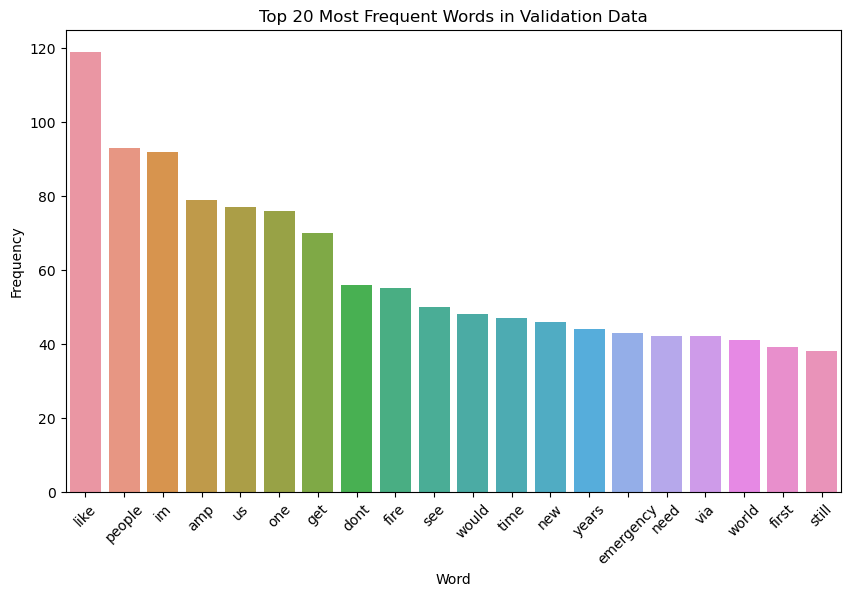

In [458]:
# Word Frequency Plot
train_word_freq = ' '.join(train_texts).split()
val_word_freq = ' '.join(val_texts).split()

train_word_counts = pd.Series(train_word_freq).value_counts()[:20]
val_word_counts = pd.Series(val_word_freq).value_counts()[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=train_word_counts.index, y=train_word_counts.values)
plt.title('Top 20 Most Frequent Words in Training Data')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=val_word_counts.index, y=val_word_counts.values)
plt.title('Top 20 Most Frequent Words in Validation Data')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

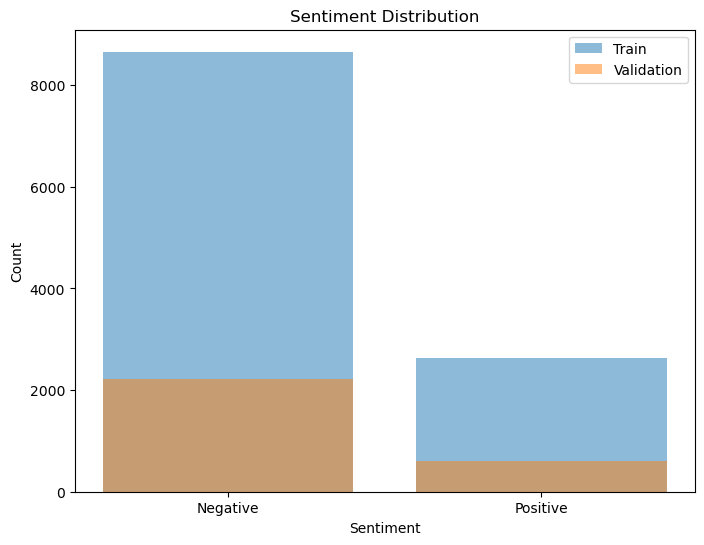

In [375]:
# Plot sentiment distribution
train_labels_np = train_labels.numpy().astype(int)
val_labels_np = val_labels.numpy().astype(int)

train_sentiment_counts = np.bincount(train_labels_np)
val_sentiment_counts = np.bincount(val_labels_np)

sentiment_labels = ['Negative', 'Positive']
x = np.arange(len(sentiment_labels))

plt.figure(figsize=(8, 6))
plt.bar(x, train_sentiment_counts, label='Train', alpha=0.5)
plt.bar(x, val_sentiment_counts, label='Validation', alpha=0.5)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(x, sentiment_labels)
plt.title('Sentiment Distribution')
plt.legend()
plt.show()


Token indices sequence length is longer than the specified maximum sequence length for this model (11289 > 512). Running this sequence through the model will result in indexing errors


vocabulary_size_tokenizer 30522


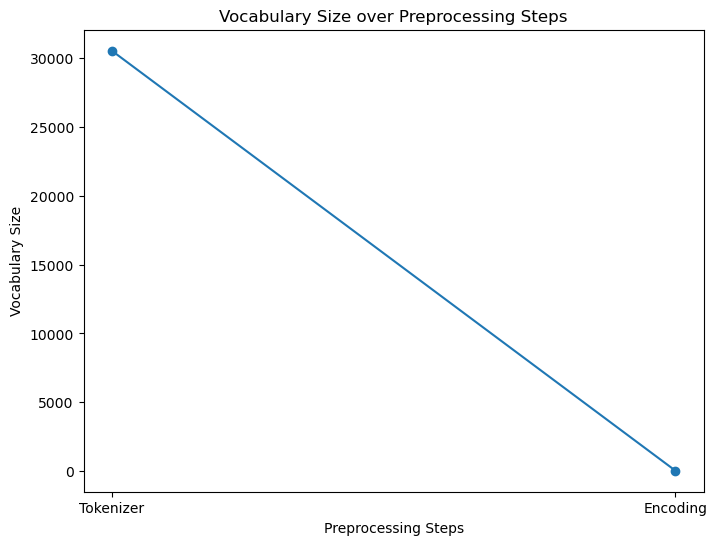

In [376]:
vocabulary_size_tokenizer = len(tokenizer.get_vocab())
print('vocabulary_size_tokenizer', vocabulary_size_tokenizer)
vocabulary_size_encoding = len(set(tokenizer.encode(train_texts)))

preprocessing_steps = ['Tokenizer', 'Encoding']
vocabulary_sizes = [vocabulary_size_tokenizer, vocabulary_size_encoding]

plt.figure(figsize=(8, 6))
plt.plot(preprocessing_steps, vocabulary_sizes, marker='o')
plt.xlabel('Preprocessing Steps')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size over Preprocessing Steps')
plt.show()


In [377]:
# Fit the topic model on your text data
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probabilities = topic_model.fit_transform(train_texts)
freq = topic_model.get_topic_info(); freq.head(5)



Batches:   0%|          | 0/353 [00:00<?, ?it/s]

2023-06-11 14:01:54,750 - BERTopic - Transformed documents to Embeddings
2023-06-11 14:01:59,314 - BERTopic - Reduced dimensionality
2023-06-11 14:02:17,794 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4218,-1_amp_like_im_one,"[amp, like, im, one, people, dont, new, us, ge...","[crazy phone much damage person, man fallen ri..."
1,0,135,0_demolition_demolish_demolished_property,"[demolition, demolish, demolished, property, e...",[enugu government demolish illegal structures ...
2,1,133,1_hindus_militants_davinder_singh,"[hindus, militants, davinder, singh, bhainsa, ...",[udhampur terror attack militants attack polic...
3,2,121,2_bernie_warren_sanders_election,"[bernie, warren, sanders, election, republican...",[true bernie sanders doesnt believe woman beat...
4,3,115,3_drown_drowning_drowned_save,"[drown, drowning, drowned, save, clev, swim, p...","[drowning, drowning, drowning]"


In [378]:
topic_model.get_topic(0)

[('demolition', 0.06988872391598382),
 ('demolish', 0.06935854924387869),
 ('demolished', 0.03997450275703118),
 ('property', 0.0235281970207906),
 ('enugu', 0.0227184638998109),
 ('rubble', 0.022424575616985576),
 ('house', 0.019459012824730577),
 ('buildings', 0.018643794049454473),
 ('shanty', 0.016315801821122793),
 ('apartment', 0.016227474214150644)]

In [379]:
topic_model.visualize_barchart(top_n_topics=12)

In [380]:
# Define the BERT model
class BERTClassifier(nn.Module):
    def __init__(self):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        output = self.sigmoid(linear_output)
        return output


In [381]:
# Create the BERT classifier model
model = BERTClassifier()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Create data loaders for training and validation
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, val_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [382]:
num_epochs = 25
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_labels = torch.round(outputs.squeeze())
        total_correct += (predicted_labels == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_dataset)

    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), labels)

            total_loss += loss.item()
            predicted_labels = torch.round(outputs.squeeze())
            total_correct += (predicted_labels == labels).sum().item()

    val_loss = total_loss / len(val_loader)
    val_acc = total_correct / len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 1/25, Train Loss: 0.3779, Train Acc: 0.8429, Val Loss: 0.3207, Val Acc: 0.8760
Epoch: 2/25, Train Loss: 0.2666, Train Acc: 0.8978, Val Loss: 0.3165, Val Acc: 0.8763
Epoch: 3/25, Train Loss: 0.1679, Train Acc: 0.9401, Val Loss: 0.3849, Val Acc: 0.8717
Epoch: 4/25, Train Loss: 0.0932, Train Acc: 0.9699, Val Loss: 0.4323, Val Acc: 0.8629
Epoch: 5/25, Train Loss: 0.0559, Train Acc: 0.9803, Val Loss: 0.5962, Val Acc: 0.8639
Epoch: 6/25, Train Loss: 0.0436, Train Acc: 0.9848, Val Loss: 0.5615, Val Acc: 0.8675
Epoch: 7/25, Train Loss: 0.0395, Train Acc: 0.9851, Val Loss: 0.6208, Val Acc: 0.8703
Epoch: 8/25, Train Loss: 0.0267, Train Acc: 0.9898, Val Loss: 0.7076, Val Acc: 0.8675
Epoch: 9/25, Train Loss: 0.0264, Train Acc: 0.9891, Val Loss: 0.7481, Val Acc: 0.8583
Epoch: 10/25, Train Loss: 0.0248, Train Acc: 0.9895, Val Loss: 0.7620, Val Acc: 0.8561
Epoch: 11/25, Train Loss: 0.0298, Train Acc: 0.9886, Val Loss: 0.6331, Val Acc: 0.8618
Epoch: 12/25, Train Loss: 0.0242, Train Acc: 0.9901,

In [383]:
torch.save(model,'BERTClassifier.pt')

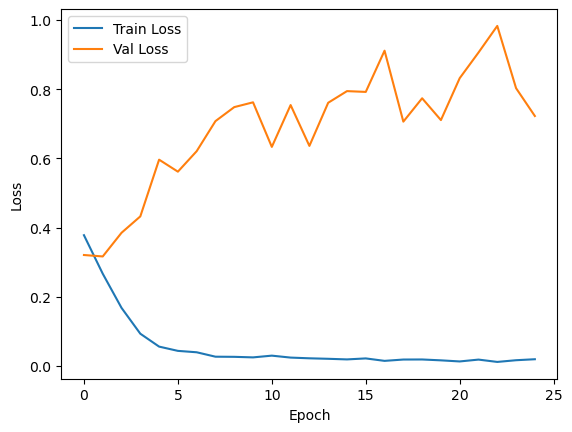

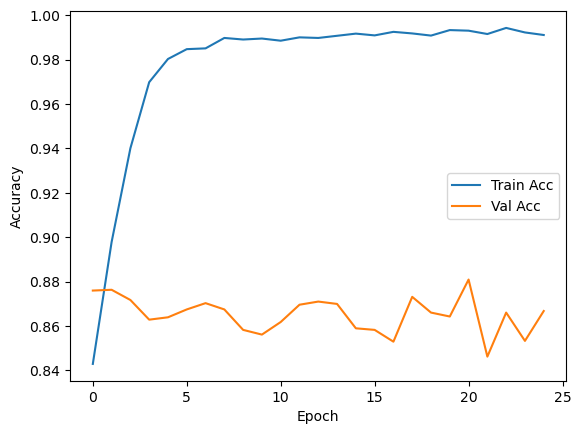

In [463]:
# Plot the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [385]:
model =  torch.load('BERTClassifier.pt')
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [397]:
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_mask)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)  # Create new test loader
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask)
        predicted_labels = torch.round(outputs.squeeze())
        predictions.extend(predicted_labels.tolist())


In [406]:
true_labels = df_test['target'].tolist()
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
# Print the evaluation measures
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8195
Precision: 0.8725
Recall: 0.6927
F1 Score: 0.7723


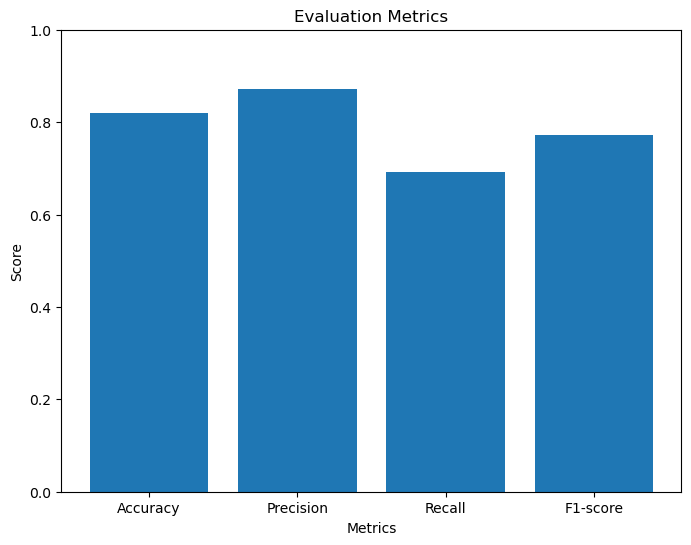

In [404]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores)
plt.ylim([0, 1])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics')

plt.show()

[[2502  218]
 [ 662 1492]]


Text(0.5, 1.0, 'Confusion Matrix')

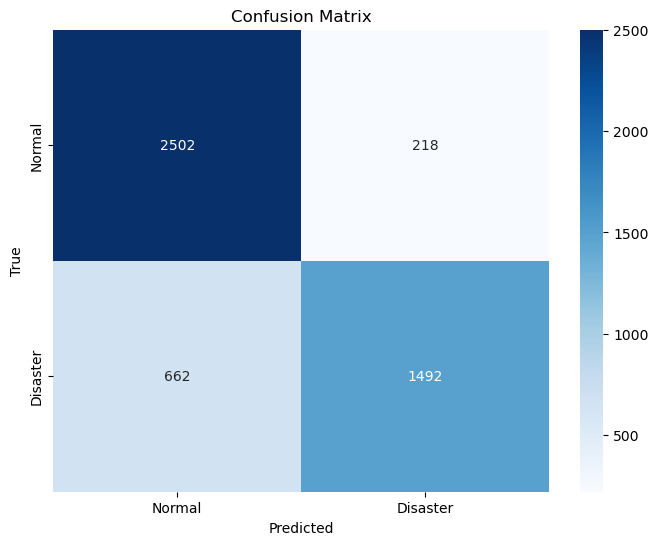

In [464]:
cm = confusion_matrix(true_labels, predictions)
print(cm)
labels = ['Normal', 'Disaster']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [405]:
# Load the pre-trained English model
nlp = spacy.load('en_core_web_sm')

extracted_locations = []

for tweet in df_train['cleaned_text']:
    if pd.isnull(tweet):
        locations = []
    else:
        doc = nlp(tweet)
        
        locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    extracted_locations.append(locations)

df_train['extracted_locations'] = extracted_locations

print(df_train[['cleaned_text', 'extracted_locations']])


                                           cleaned_text extracted_locations
8165                          onion phone w police like                  []
3275  tomorrow kick weekend drinks amp entertainment...                  []
5865     lol real issue way nfl trying ruin guys legacy                  []
7639  dont want america know unmitigating disaster i...           [america]
6176  cj saying compensation victims theres compensa...                  []
...                                                 ...                 ...
3612  insisting intra afghan dialogues signing agree...                  []
1338  body year old girl reported missing kayole hom...           [nairobi]
5072  natural unavoidable consequence socialism ever...                  []
8254  somebody come quarantine nigga decide around s...                  []
687   turn radios stoponesounds live airwaves amp fm...                  []

[9029 rows x 2 columns]


In [459]:
# Function to geocode a location
def geocode_location(location):
    geolocator = Nominatim(user_agent="my_app")
    geocode = geolocator.geocode(location)
    return geocode.latitude, geocode.longitude

disaster_location = 'hiroshima'
lat, lon = geocode_location(disaster_location)
map_obj = folium.Map(location=[lat, lon], zoom_start=10)
folium.Marker([lat, lon], popup=disaster_location, icon=folium.Icon(color='red')).add_to(map_obj)
map_obj.save('map.html')
IFrame(src='map.html', width=700, height=600)